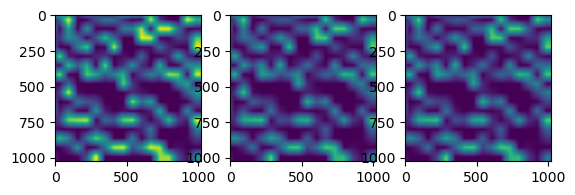

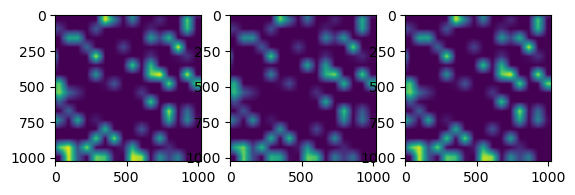

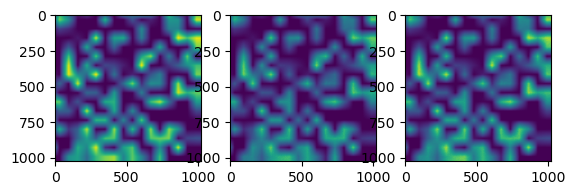

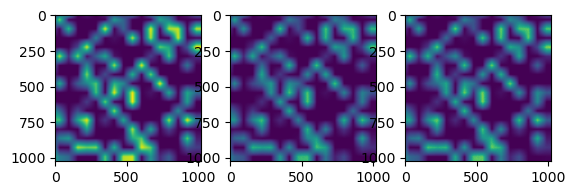

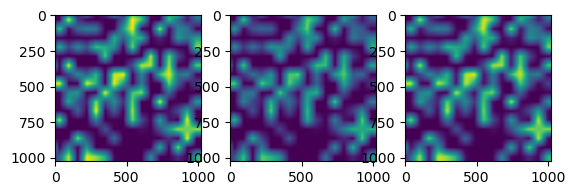

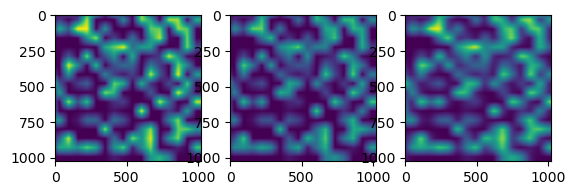

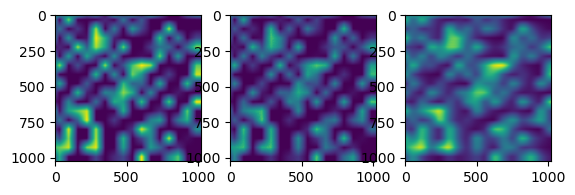

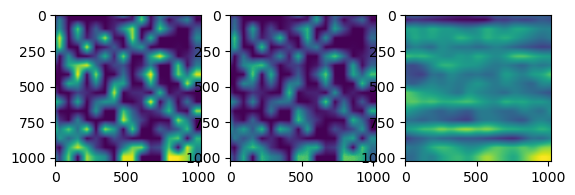

In [2]:
import numpy as np
import os
import cv2
from PIL import Image
from scipy.ndimage import zoom
from scipy.signal import lfilter
from skimage.util import random_noise
from matplotlib import pyplot as plt

def elementaryCellularAutomata(rule, n, width=None, randfrac=None):
    # Validate inputs
    if not (0 <= rule <= 255):
        raise ValueError("Rule should be an integer between 0 and 255.")
    
    if not isinstance(n, int) or n <= 0:
        raise ValueError("N should be a positive integer.")
    
    if width is None:
        width = 2 * n - 1
    
    if isinstance(width, int):
        if width <= 0:
            raise ValueError("Width should be a positive integer.")
        patt = np.ones(width, dtype=int)
        patt[(width+1)//2 - 1] = 2
    else:
        if not all(map(lambda x: x in [0, 1], width)):
            raise ValueError("Width should be a list of 0s and 1s only.")
        patt = np.array(width) + 1
        width = len(patt)
    
    if randfrac is not None:
        if not (0 <= randfrac <= 1):
            raise ValueError("Randfrac should be a float between 0 and 1.")
        dorand = True
    else:
        dorand = False
    
    # Unpack rule
    rulearr = [(rule >> i) & 1 for i in range(8)]
    rulearr = np.array(rulearr) + 1
    
    # Initialize output pattern
    pattern = np.zeros((n, width), dtype=int)
    
    # Generate the pattern
    for i in range(n):
        pattern[i, :] = patt
        ind = 2**2 * np.roll(patt, 1) + 2**1 * patt + 2**0 * np.roll(patt, -1)
        ind = ind % 8  # Ensure indices are within 0-7
        patt = rulearr[ind]
        
        # Optional randomization
        if dorand:
            flip = np.random.rand(width) < randfrac
            patt[flip] = 3 - patt[flip]
    
    # Convert 1 and 2 to 0 and 1
    pattern -= 1
    
    return pattern

def caimgen(lp_length, imgsize):
    mask = elementaryCellularAutomata(np.random.randint(255), lp_length, lp_length, np.random.random())
    pix_value = np.round(np.random.rand(lp_length, lp_length) * 4095).astype(int)
    imgseed = np.array(mask * pix_value, dtype=np.double)
    
    imgraw = cv2.resize(imgseed, (imgsize * 2, imgsize * 2))  # Double the image size
    imgraw = imgraw[imgsize-1:2*imgsize-1, :]  # Crop the image
    return imgraw

def blurgen(img_gt, k):
    img_gtf = np.zeros_like(img_gt)
    
    # filter coefficients
    b = [0, k]
    a = [1, -(1-k)]
    
    for i in range(img_gt.shape[0]):
        img_gtf[i, :] = lfilter(b, a, img_gt[i, :])
    return img_gtf

k = [1, 0.189, 0.189*2, 0.189*4, 0.189/2, 0.189/5, 0.189/10, 0.189/100]

base_path = '/home/xavier/Documents/Tao-ImageSet/python_synthesized'

for fidx in range(1):
    folderpath = os.path.join(base_path, 'group_' + str(fidx))
    os.makedirs(folderpath, exist_ok=True)
    os.chdir(folderpath)
    
    lp_length = int(32 * 2**fidx)
    
    for j in k:
        subfname = str(j)
        os.makedirs(subfname, exist_ok=True)
        
        for i in range(1):
            img_temp = caimgen(lp_length, 1024)
            # Adding noise and blurring (assuming speckle noise and blur functions are defined)
            img_temp2 = random_noise(np.uint16(img_temp), mode='speckle') # img_temp + np.random.randn(*img_temp.shape)
            img_blur_temp = blurgen(img_temp2, j)
            
            img_gt = img_temp[:, 1024:]
            img_gtn = img_temp2[:, 1024:]
            img_blur = img_blur_temp[:, 1024:]
            fig, axs = plt.subplots(1, 3)
            axs[0].imshow(img_gt)
            axs[1].imshow(img_gtn)
            axs[2].imshow(img_blur)
            plt.show()
            Image.fromarray(img_gt.astype(np.uint16)).save(f'{subfname}/gt_k={j}_{i}.tif')
            Image.fromarray(img_gtn.astype(np.uint16)).save(f'{subfname}/gtn_k={j}_{i}.tif')
            Image.fromarray(img_blur.astype(np.uint16)).save(f'{subfname}/k={j}_{i}.tif')
        
        os.chdir(folderpath)
